In [3]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
import json
import csv
from PIL import Image
from tqdm import tqdm
import string
import time
import collections
import matplotlib.pyplot as plt
import networkx as nx
from tabulate import tabulate

# 1 Dataset analysis
The dataset used to train and validate the scene recognition models is [Places365](http://places2.csail.mit.edu/index.html).
Download the validation set:
```
mkdir places365_data
cd places365_data
curl -o http://data.csail.mit.edu/places/places365/val_large.tar
tar xopf val_large.tar
```
```
cd ..
mkdir annotations
wget http://data.csail.mit.edu/places/places365/filelist_places365-standard.tar
tar xopf filelist_places365-standard.tar


```

In the following cells, we will show:
* The list of original classes (level-4)
* The distribution of data in validation set
* A tool to display samples, given specific class index



In [4]:
# load the list of original clases (level-4)
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

In [5]:
# load ground truth
    
with open ('../places365_data/annotations/places365_val.txt','r') as f:
    gts = f.readlines()
gts_x = [i.split()[0][10:-4] for i in gts]
gts_y = [i.split()[1] for i in gts]
gts = {}
for i in range(len(gts_x)):
    gts[gts_x[i]] = int(gts_y[i])
gt = [int(a) for a in list(gts.values())]
gt_dist = {}
for i in gt:
    if i not in gt_dist.keys():
        gt_dist[i] = 1
    else:
        gt_dist[i] +=1
gt_dist=collections.OrderedDict(sorted(gt_dist.items()))

# classify val data based on categories
gts_classes = {}
for i in range(365):
    gts_classes[i] = []
for key in gts.keys():
    gts_classes[gts[key]].append(key)
    
for key in gt_dist.keys():
    print('{}: {}'.format(classes[key],gt_dist[key]))

airfield: 100
airplane_cabin: 100
airport_terminal: 100
alcove: 100
alley: 100
amphitheater: 100
amusement_arcade: 100
amusement_park: 100
apartment_building/outdoor: 100
aquarium: 100
aqueduct: 100
arcade: 100
arch: 100
archaelogical_excavation: 100
archive: 100
arena/hockey: 100
arena/performance: 100
arena/rodeo: 100
army_base: 100
art_gallery: 100
art_school: 100
art_studio: 100
artists_loft: 100
assembly_line: 100
athletic_field/outdoor: 100
atrium/public: 100
attic: 100
auditorium: 100
auto_factory: 100
auto_showroom: 100
badlands: 100
bakery/shop: 100
balcony/exterior: 100
balcony/interior: 100
ball_pit: 100
ballroom: 100
bamboo_forest: 100
bank_vault: 100
banquet_hall: 100
bar: 100
barn: 100
barndoor: 100
baseball_field: 100
basement: 100
basketball_court/indoor: 100
bathroom: 100
bazaar/indoor: 100
bazaar/outdoor: 100
beach: 100
beach_house: 100
beauty_salon: 100
bedchamber: 100
bedroom: 100
beer_garden: 100
beer_hall: 100
berth: 100
biology_laboratory: 100
boardwalk: 100
boat

airplane_cabin


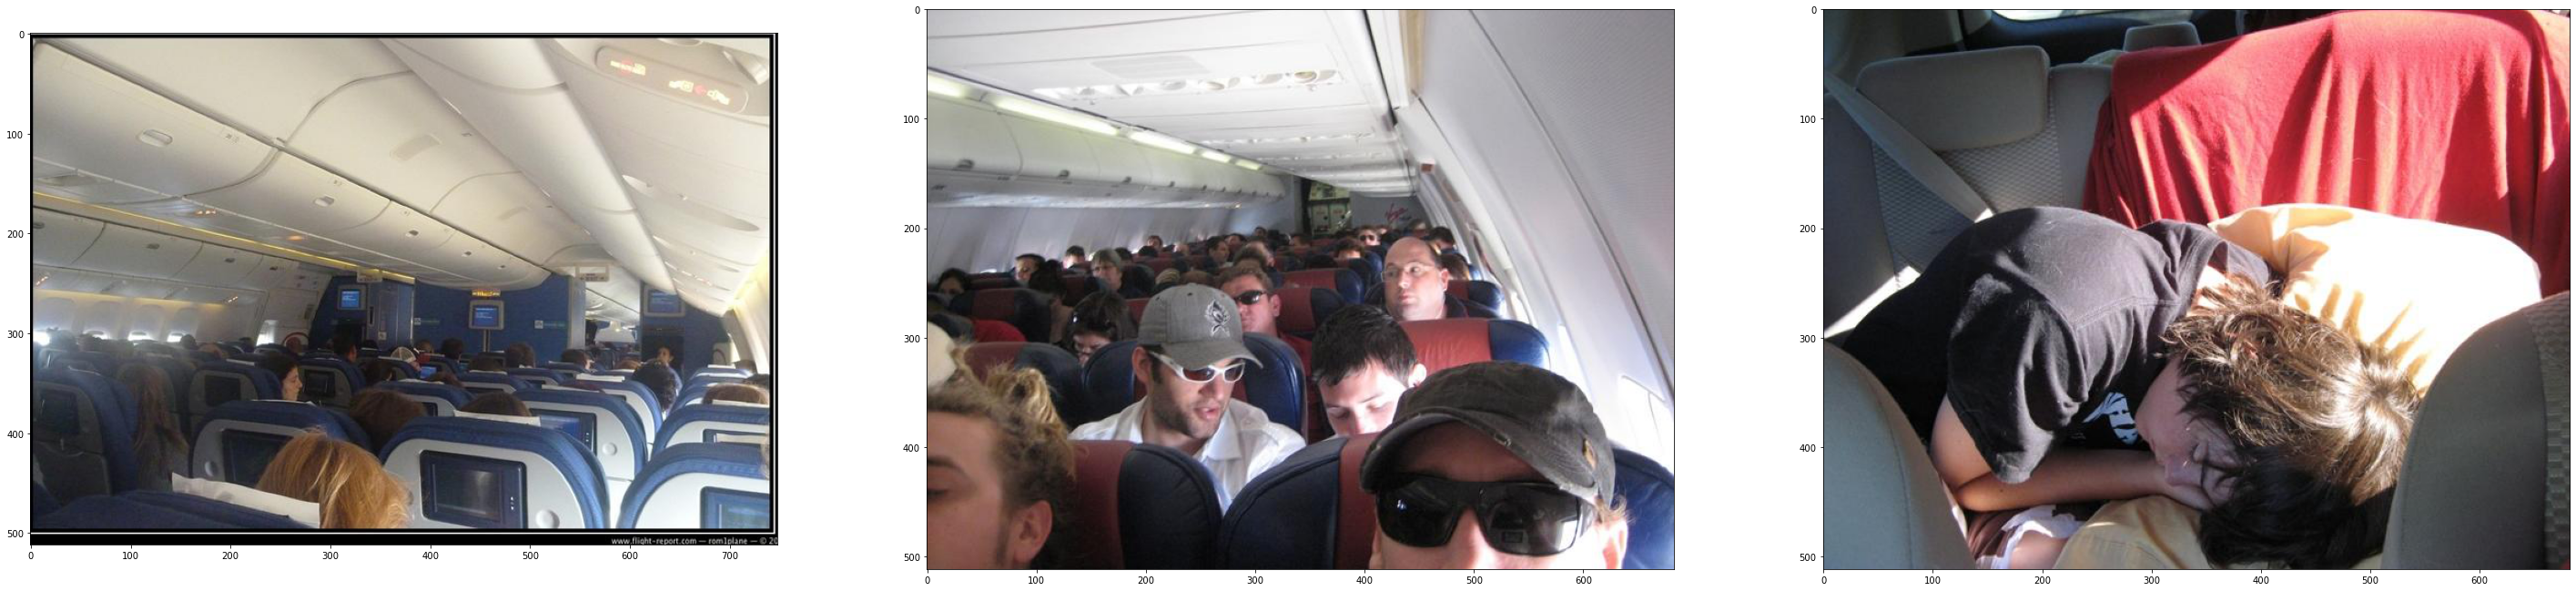

In [6]:
# explore the validation set

# give the index of class, and return the list of images belong to that category
def show_example (num_class):
    index = [i for i, e in enumerate(gts.values()) if int(e) == num_class]
    imgs_index = [e for i,e in enumerate(gts.keys()) if i in index]
    return imgs_index

classNum = 1
imgs_list = show_example(classNum)
print(classes[classNum])
fig=plt.figure(figsize=(50, 50))

columns = 3
rows = 1
for i in range(1, columns*rows +1):
    img_path = '../places365_data/val_large/Places365_{}.jpg'.format(imgs_list[i])
    image = Image.open(img_path)
    image = np.array(image, dtype=np.uint8)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

# 2 Single image inference
* Set the backbone network 
    * resnet50
    * resnet18
    * alexnet
* Load the pretrained model
* Input the image
* Return top-N predictions

resnet50 prediction on 12.jpg
0.685 -> patio
0.240 -> restaurant_patio
0.019 -> beer_garden
0.010 -> courtyard
0.010 -> porch
0.010 -> diner/outdoor
0.005 -> roof_garden
0.004 -> yard
0.003 -> coffee_shop
0.002 -> inn/outdoor


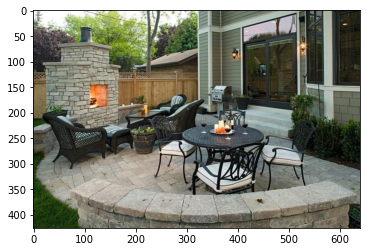

In [7]:
# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)
    
model = models.__dict__[arch](num_classes=365)
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
model.eval()

# load the image transformer
centre_crop = trn.Compose([
        trn.Resize((256,256)),
        trn.CenterCrop(224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load the test image
img_name = '12.jpg'
if not os.access(img_name, os.W_OK):
    img_url = 'http://places.csail.mit.edu/demo/' + img_name
    os.system('wget ' + img_url)
img = Image.open(img_name)
plt.imshow(img)
input_img = V(centre_crop(img).unsqueeze(0))

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)

print('{} prediction on {}'.format(arch,img_name))
# output the prediction
for i in range(0, 10):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# 3 Performance analysis
## 3.1 Level 4: 365 categories

In [ ]:
# evaluate all sample in the validation set and save the results into a csv file.
backbone_network = 'resnet50'
val_path = '../places365_data/val_large/'
val_data = os.listdir(val_path)
val_data.sort()
# model = VGG16_Places365(weights='places')

# def save_prob_idx (prob,idx):
#     sample = {}
#     for i in range(int(prob.size()[0])):
#         sample[int(idx[i])]= float(prob[i])
#     return sample

def validation(arch):
# resnet50, resnet18, alexnet
    model_file = '%s_places365.pth.tar' % arch
    print(model_file)
    
    if not os.access(model_file, os.W_OK):
        weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
        os.system('wget ' + weight_url)

    model = models.__dict__[arch](num_classes=365)
    model.cuda()
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()
    
    centre_crop = trn.Compose([
            trn.Resize((256,256)),
            trn.CenterCrop(224),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # start to val
    val_res = []
    count = 0
    for data in tqdm(val_data):
        image = Image.open(os.path.join(val_path,data)).convert('RGB') 
        input_img = V(centre_crop(image).unsqueeze(0)).cuda()
        # forward pass
        logit = model.forward(input_img)
#         print(logit)
        h_x = F.softmax(logit, 1).data.squeeze()
#         print(h_x)
#         probs, idx = h_x.sort(0, True)
        name = data[10:-4]
#         dt_y = save_prob_idx(probs,idx)
        dt_y = h_x.tolist()
        dt_y.insert(0,name)
        val_res.append(dt_y)

    return val_res


val = validation(backbone_network)

print('total {} samples'.format(len(val)))

# Write into a csv file

with open('val_results_{}.csv'.format(backbone_network),'w') as f:
    writer = csv.writer(f)
    for row in val:
        writer.writerow(row)

# Read the preditctions
with open('val_results_{}.csv'.format(backbone_network),"r") as csvfile:
    reader = csv.reader(csvfile)
    dts = []
    for line in reader:
        dts.append(line)
print('total {} samples'.format(len(dts)))

resnet50_places365.pth.tar


  1%|▏         | 483/36500 [00:10<09:39, 62.18it/s]  

In [8]:
def top1_prediction (dt):
#     print(len(dt))
    new_dt = [float(i) for i in dt]
    m = max(new_dt)
#     print(m)
    top1 = [i for i, j in enumerate(new_dt) if j == m]
    return top1

def top1_accuracy(dts,gts):
    total = 0
    accurate = 0
    pc_total = [0 for i in range(365)]
    pc_accurate = [0 for i in range(365)]
    for key in dts.keys():
        if dts[key] == gts[key]:
            accurate +=1
            pc_accurate[gts[key]] +=1
        total += 1
        pc_total[gts[key]] +=1
    return accurate/total, pc_total, pc_accurate

def top1_accuracy_highLevel(dts,gts):
    total = 0
    accurate = 0
    for key in gts.keys():
        pc_total = [0 for i in range(len(gts[key]))]
        pc_accurate = [0 for i in range(len(gts[key]))]
        break
        
    for key in gts.keys():
        for i in range(len(gts[key])):
            if gts[key][i] == 1:
                pc_total[i]+=1
                total+=1
                if dts[key][i] == 1:
                    pc_accurate[i] +=1
                    accurate += 1
    acc = accurate/total
#     pc_acc = [pc_accurate[i]/pc_total[i] for i in range(len(pc_total))]
    
    return acc, pc_total,pc_accurate


def top1_accuracy_clean(dts,gts,cluster):
    total = 0
    accurate = 0
    for key in dts.keys():
        gt = gts[key]
        dt = dts[key]
        
        if dt == gt:
            accurate +=1
        if gt in cluster.keys():
            if dt in cluster[gt]:
                accurate += 1
        total += 1
    return accurate/total


In [9]:
# load detection results
backbone_network = 'resnet50'
with open('val_results_{}.csv'.format(backbone_network),"r") as csvfile:
    reader = csv.reader(csvfile)
    dts = []
    for line in reader:
        dts.append(line)

# top-1 accuracy
dts_top1 = {}
for dt in dts:
    dts_top1[dt[0]] = top1_prediction(dt[1:])[0]



In [10]:
top1,pc_total_4,pc_accurate_4 = top1_accuracy(dts_top1,gts)
print('Top-1 accuracy of {} at level 4 is {}'.format(backbone_network,float(top1)))
pc_acc_4 = []
for i in range (len(pc_total_4)):
    acc_4 = float(pc_accurate_4[i]/pc_total_4[i])
    pc_acc_4.append(acc_4)

Top-1 accuracy of resnet50 at level 4 is 0.5508767123287671


In [11]:

table = [[classes[i],pc_total_4[i],pc_accurate_4[i],pc_acc_4[i]] for i in range(365)]
print(tabulate(table, headers=['class', 'total number','correct preditions','accuracy']))

class                         total number    correct preditions    accuracy
--------------------------  --------------  --------------------  ----------
airfield                               100                    54        0.54
airplane_cabin                         100                    85        0.85
airport_terminal                       100                    51        0.51
alcove                                 100                    30        0.3
alley                                  100                    52        0.52
amphitheater                           100                    75        0.75
amusement_arcade                       100                    73        0.73
amusement_park                         100                    51        0.51
apartment_building/outdoor             100                    37        0.37
aquarium                               100                    74        0.74
aqueduct                               100                    60        0.6
a

Compute the correlation between classes:

* cor[A,B] = cor [B,A] = (# of A predicted as B +  of A predicted as B) / (# of A and B)

Larger cor means the model is more likely to wrongly take A as B, or take B as A.

Here, [correlation_resnet50_level40](https://docs.google.com/spreadsheets/d/1GUv97GD_wcoGOyoi1mmqXl1xW5fRz4lpjXN5bbZ2IH0/edit?usp=sharing), is the distribution of errors.

In [10]:
# error distribution
correlation = {}
for i in range(365):
    correlation[i] = {}
    for j in range(365):
        correlation[i][j] = 0
        
for i in range(len(y_true)):
    correlation[y_true[i]][y_pred[i]]+=1
cor = np.zeros((365, 365))
print(np.shape(cor))
for i in range(365):
    for j in range(365):
        if i != j:
            cor[i,j] = float("{:.3f}".format(cor[i,j] + correlation[i][j]/200))
            
            cor[j,i] = float("{:.3f}".format(cor[j,i] + correlation[i][j]/200))

NameError: name 'y_true' is not defined

In [11]:
cor_clean = np.zeros((365, 365))
corThre = 0.05
FG = nx.Graph()
cluster = {}
for i in range(365):
    for j in range(i,365):
        if cor[i,j] > corThre:
            FG.add_weighted_edges_from([(i, j, cor[i,j])])
            cor_clean[i,j] = cor[i,j]
            if i not in cluster.keys():
                cluster[i] = [j]
            else: 
                cluster[i].append(j)
            if j not in cluster.keys():
                cluster[j] = [i]
            else: 
                cluster[j].append(i)
            
            print(i,classes[i],j,classes[j],cor[i][j])
np.savetxt("correlation_resnet50_level4.csv",cor_clean , delimiter=",")

NameError: name 'cor' is not defined

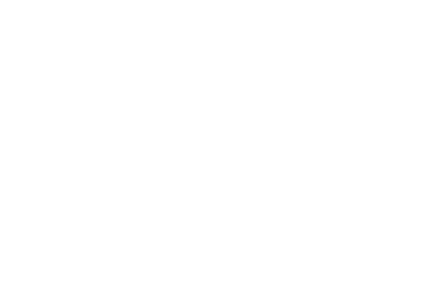

In [12]:
# visualize the correlation
options = {
    'node_color': 'red',
    'node_size': 10,
    'width': 0.3,
}
nx.draw(FG, with_labels=True,font_size=8,alpha=1,**options)
# plt.subplot(122)
plt.show()
# nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [13]:
top1 = top1_accuracy_clean(dts_top1,gts,cluster)
print('Top-1 accuracy of {} is {}'.format(backbone_network,float(top1)))

Top-1 accuracy of resnet50 is 0.5508767123287671


## 3.2 Level 1: 3 categories

Even there are just 3 categories in this level, but there are actually 5 classes because of the existence of overlaps between categories. Thus, we use three binary digits to represent the label of each sample (indoor, outdoor_nature, outdoor_manmade). E.g. 'corral' is considered as both outdoor_nature and outdoor_manmade, so its label is denoted as [0,1,1] 

If a 4th level class is part of multiple high level classes, we count it multiple times. 
E.g. giving gt = [1,0,1], dt = [1,0,0], the accuracy = 1/2


However, when we measure the per-class accuracy, e.g. indoor, the accuracy_indoor‘s denominator is the total number of samples with ground truth [1, *, *] The numerator is the number of correct predictions among them. 


In [36]:
# mapping gts to level1
lv1_names= ['indoor','outdoor,natural','outdoor, man-made']
level1 = {}
with open('./places365_level1.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        level1[int(row[0])]=[int(row[1]),int(row[2]),int(row[3])] 
# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

# load ground truth
with open ('../places365_data/annotations/places365_val.txt','r') as f:
    gts = f.readlines()
gts_x = [i.split()[0][10:-4] for i in gts]
gts_y = [i.split()[1] for i in gts]
gts = {}
for i in range(len(gts_x)):
    gts[gts_x[i]] = int(gts_y[i])

gts_lv1 = {}
for key in gts.keys():
    value = gts[key]
    gts_lv1[key] = level1[value]

In [16]:
# mapping dts to level1:
def convert_dts2level1 (dt):
#     print(len(dt))
    dt_new={}
    for key in lv1_classes.keys():
        dt_new[key] = 0
    for i in range(len(dt)):
        dt_new[lv1[i]] = float(dt[i]) + float(dt_new[lv1[i]])
    flag = 0
    temp = 0 
    for key in dt_new.keys():
        if dt_new[key] > temp:
            flag = key
            temp  = dt_new[key]
        
    return flag

temp = []
for label in level1.keys():
    if level1[label] not in temp:
        temp.append(level1[label])
lv1_classes = {}
for i in range(len(temp)):
    lv1_classes[i] = temp[i]
print(lv1_classes)

lv1 = {}
for key in level1.keys():
    lv1[key] = temp.index(level1[key])

backbone_network = 'resnet50'
with open('val_results_{}.csv'.format(backbone_network),"r") as csvfile:
    reader = csv.reader(csvfile)
    dts = []
    for line in reader:
        dts.append(line)

dts_lv1 = {}
for dt in dts:
    dts_lv1[dt[0]] = lv1_classes[convert_dts2level1(dt[1:])]

{0: [0, 0, 1], 1: [1, 0, 0], 2: [0, 1, 1], 3: [0, 1, 0], 4: [1, 0, 1]}


In [42]:
top1,pc_total,pc_accurate = top1_accuracy_highLevel(dts_lv1,gts_lv1)
print('Top-1 accuracy of {} at level-1 is {}'.format(backbone_network,float(top1)))

for i in range(len(pc_total)):
    total = pc_total[i]
    acc = float(pc_accurate[i]/pc_total[i])
    name = lv1_names[i]
    print('{} samples in: {}. The accurate is {}'.format(total,name,acc))

Top-1 accuracy of resnet50 at level-1 is 0.913643216080402
15900 samples in: indoor. The accurate is 0.9557861635220126
8000 samples in: outdoor,natural. The accurate is 0.846875
15900 samples in: outdoor, man-made. The accurate is 0.9050943396226415


In [94]:
pc_total_1 = [0 for i in range(365)]
pc_accurate_1 = [0 for i in range(365)]
for cat in gts_classes.keys():
    dts_temp = {}
    gts_temp = {}
    for sample in gts_classes[cat]:
        dts_temp[sample] = dts_lv1[sample]
        gts_temp[sample] = gts_lv1[sample]

    for key in gts_temp.keys():
        for i in range(len(gts_temp[key])):
            if gts_temp[key][i] == 1:
                pc_total_1[cat] += 1
                if dts_temp[key][i] == 1:
                    pc_accurate_1[cat] +=1
pc_acc_1 = [pc_accurate_1[i]/pc_total_1[i] for i in range(365)]

In [95]:
table = [[classes[i],pc_acc_4[i],pc_acc_1[i],pc_acc_1[i]-pc_acc_4[i]] for i in range(365)]
print(tabulate(table, headers=['class', 'level_4 accuracy','level_1 accuracy','gain']))

class                         level_4 accuracy    level_1 accuracy    gain
--------------------------  ------------------  ------------------  ------
airfield                                  0.54               0.99    0.45
airplane_cabin                            0.85               0.98    0.13
airport_terminal                          0.51               0.97    0.46
alcove                                    0.3                0.91    0.61
alley                                     0.52               0.84    0.32
amphitheater                              0.75               0.95    0.2
amusement_arcade                          0.73               0.99    0.26
amusement_park                            0.51               0.82    0.31
apartment_building/outdoor                0.37               0.99    0.62
aquarium                                  0.74               0.85    0.11
aqueduct                                  0.6                0.895   0.295
arcade                              

## 3.3 Level 2: 16 categories

In [39]:
# mapping gts to level2
lv2_names = ['shopping and dining','workplace (office building, factory, lab, etc.)','home or hotel','transportation (vehicle interiors, stations, etc.)','sports and leisure','cultural (art, education, religion, millitary, law, politics, etc.)','water, ice, snow','mountains, hills, desert, sky','forest, field, jungle','man-made elements','transportation (roads, parking, bridges, boats, airports, etc.)','cultural or historical building/place (millitary, religious)','sports fields, parks, leisure spaces','industrial and construction','houses, cabins, gardens, and farms','commercial buildings, shops, markets, cities, and towns']
level2 = {}
with open('./places365_level2.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        level2[int(row[0])]=[int(row[a]) for a in range(1,len(row))]
# load the class label
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes = tuple(classes)

# load ground truth
with open ('../places365_data/annotations/places365_val.txt','r') as f:
    gts = f.readlines()
gts_x = [i.split()[0][10:-4] for i in gts]
gts_y = [i.split()[1] for i in gts]
gts = {}
for i in range(len(gts_x)):
    gts[gts_x[i]] = int(gts_y[i])

gts_lv2 = {}
for key in gts.keys():
    value = gts[key]
    gts_lv2[key] = level2[value]


In [19]:
# mapping dts to level1:
backbone_network = 'resnet50'
with open('val_results_{}.csv'.format(backbone_network),"r") as csvfile:
    reader = csv.reader(csvfile)
    dts = []
    for line in reader:
        dts.append(line)

temp = []
for label in level2.keys():
    if level2[label] not in temp:
        temp.append(level2[label])
lv2_classes = {}
for i in range(len(temp)):
    lv2_classes[i] = temp[i]
# print(lv2_classes)

lv2 = {}
for key in level2.keys():
    lv2[key] = temp.index(level2[key])
# lv1 mapping original class_id to level1_id  

def convert_dts2level2 (dt):
#     print(len(dt))
    dt_new={}
    for key in lv2_classes.keys():
        dt_new[key] = 0
    for i in range(len(dt)):
        dt_new[lv2[i]] = float(dt[i]) + float(dt_new[lv2[i]])
    flag = 0
    temp = 0 
    for key in dt_new.keys():
        if dt_new[key] > temp:
            flag = key
            temp  = dt_new[key]
        
    return flag

dts_lv2 = {}
for dt in dts:
    dts_lv2[dt[0]] = lv2_classes[convert_dts2level2(dt[1:])]


In [41]:
top1,pc_total,pc_accurate = top1_accuracy_highLevel(dts_lv2,gts_lv2)
print('Top-1 accuracy of {} at level-2 is {}'.format(backbone_network,float(top1)))

for i in range(len(pc_total)):
    total = pc_total[i]
    acc = float(pc_accurate[i]/pc_total[i])
    name = lv2_names[i]
    print('{} samples in: {}. The accurate is {}'.format(total,name,acc))

Top-1 accuracy of resnet50 at level-2 is 0.7568478260869566
4400 samples in: shopping and dining. The accurate is 0.8136363636363636
3500 samples in: workplace (office building, factory, lab, etc.). The accurate is 0.7325714285714285
3100 samples in: home or hotel. The accurate is 0.7941935483870968
1600 samples in: transportation (vehicle interiors, stations, etc.). The accurate is 0.746875
1700 samples in: sports and leisure. The accurate is 0.8311764705882353
3000 samples in: cultural (art, education, religion, millitary, law, politics, etc.). The accurate is 0.7486666666666667
3300 samples in: water, ice, snow. The accurate is 0.8224242424242424
1400 samples in: mountains, hills, desert, sky. The accurate is 0.7042857142857143
3100 samples in: forest, field, jungle. The accurate is 0.7416129032258064
3200 samples in: man-made elements. The accurate is 0.6815625
2500 samples in: transportation (roads, parking, bridges, boats, airports, etc.). The accurate is 0.6928
3100 samples in: 

In [97]:
pc_total_2 = [0 for i in range(365)]
pc_accurate_2 = [0 for i in range(365)]
for cat in gts_classes.keys():
    dts_temp = {}
    gts_temp = {}
    for sample in gts_classes[cat]:
        dts_temp[sample] = dts_lv2[sample]
        gts_temp[sample] = gts_lv2[sample]

    for key in gts_temp.keys():
        for i in range(len(gts_temp[key])):
            if gts_temp[key][i] == 1:
                pc_total_2[cat] += 1
                if dts_temp[key][i] == 1:
                    pc_accurate_2[cat] +=1
pc_acc_2 = [pc_accurate_2[i]/pc_total_2[i] for i in range(365)]

In [98]:
table = [[classes[i],pc_acc_4[i],pc_acc_2[i],pc_acc_2[i]-pc_acc_4[i]] for i in range(365)]
print(tabulate(table, headers=['class', 'level_4 accuracy','level_2 accuracy','gain']))

class                         level_4 accuracy    level_2 accuracy        gain
--------------------------  ------------------  ------------------  ----------
airfield                                  0.54            0.97       0.43
airplane_cabin                            0.85            0.92       0.07
airport_terminal                          0.51            0.58       0.07
alcove                                    0.3             0.68       0.38
alley                                     0.52            0.77       0.25
amphitheater                              0.75            0.8        0.05
amusement_arcade                          0.73            0.75       0.02
amusement_park                            0.51            0.66       0.15
apartment_building/outdoor                0.37            0.8        0.43
aquarium                                  0.74            0.8        0.06
aqueduct                                  0.6             0.83       0.23
arcade                      

# 4 Error analysis
# 4.1 Error Distribution

In [21]:
dts_top1
gts
error_dis = np.zeros([365,365])

In [22]:
for key in gts.keys():
    error_dis[gts[key]][dts_top1[key]] += 1
error_dis = error_dis /100
print('the size of error distribution matrix is: {}'.format(np.shape(error_dis)))

the size of error distribution matrix is: (365, 365)


In [53]:
from sklearn.cluster import AgglomerativeClustering
X = error_dis
numCluster = 100
clustering = AgglomerativeClustering(n_clusters=numCluster,linkage='complete',affinity='cosine').fit(X)
cluster_label = clustering.labels_.tolist()
print(cluster_label)

[70, 21, 14, 13, 90, 56, 54, 1, 9, 92, 55, 85, 60, 74, 64, 44, 8, 69, 10, 5, 4, 5, 37, 7, 94, 85, 13, 42, 7, 19, 34, 25, 9, 65, 1, 24, 73, 49, 29, 18, 20, 58, 89, 3, 26, 68, 0, 75, 22, 36, 47, 31, 31, 75, 18, 31, 50, 91, 22, 40, 64, 47, 98, 37, 79, 57, 55, 9, 69, 13, 97, 14, 25, 34, 20, 29, 2, 11, 40, 40, 46, 34, 19, 1, 81, 13, 93, 88, 50, 77, 24, 81, 86, 50, 34, 71, 0, 22, 21, 18, 45, 86, 86, 11, 82, 12, 96, 33, 9, 56, 72, 28, 48, 40, 25, 0, 61, 61, 61, 87, 29, 29, 42, 58, 31, 11, 71, 36, 87, 49, 49, 13, 9, 7, 6, 6, 74, 0, 20, 18, 82, 82, 52, 78, 17, 23, 0, 98, 18, 94, 73, 52, 52, 66, 16, 51, 3, 36, 35, 27, 0, 87, 0, 28, 32, 62, 62, 60, 26, 3, 17, 22, 46, 82, 70, 52, 45, 15, 11, 50, 80, 9, 31, 33, 88, 18, 41, 41, 44, 44, 41, 28, 11, 9, 22, 43, 96, 23, 5, 76, 56, 59, 4, 51, 22, 84, 76, 70, 99, 66, 86, 86, 64, 9, 53, 37, 17, 15, 40, 49, 9, 36, 0, 75, 84, 57, 81, 90, 6, 40, 81, 35, 34, 34, 28, 42, 5, 9, 8, 5, 77, 4, 33, 22, 45, 11, 45, 22, 50, 38, 8, 16, 81, 46, 2, 3, 11, 63, 82, 65, 27,

In [54]:
level3 = {}
for num in range(numCluster):
    level3[num] = [classes[i] for i, j in enumerate(cluster_label) if j == num]
level3

{0: ['bazaar/indoor',
  'clothing_store',
  'department_store',
  'fabric_store',
  'flea_market/indoor',
  'general_store/indoor',
  'gift_shop',
  'market/indoor',
  'shoe_shop'],
 1: ['amusement_park', 'ball_pit', 'carrousel'],
 2: ['campsite', 'park', 'picnic_area', 'playground'],
 3: ['basement', 'garage/indoor', 'hangar/indoor', 'parking_garage/indoor'],
 4: ['art_school', 'kindergarden_classroom', 'nursing_home', 'sandbox'],
 5: ['art_gallery',
  'art_studio',
  'jewelry_shop',
  'museum/indoor',
  'natural_history_museum',
  'science_museum'],
 6: ['entrance_hall', 'escalator/indoor', 'mezzanine', 'staircase'],
 7: ['assembly_line',
  'auto_factory',
  'engine_room',
  'physics_laboratory',
  'repair_shop',
  'server_room',
  'storage_room'],
 8: ['arena/performance',
  'music_studio',
  'orchestra_pit',
  'stage/outdoor',
  'television_studio'],
 9: ['apartment_building/outdoor',
  'balcony/exterior',
  'building_facade',
  'courthouse',
  'embassy',
  'hotel/outdoor',
  'inn/

In [55]:
gts_lv3 = {}
for key in gts.keys():
    gts_lv3[key] = cluster_label[gts[key]]
dts_lv3 = {}
for key in dts_top1.keys():
    dts_lv3[key] = cluster_label[dts_top1[key]]

In [56]:
top1,pc_total_3,pc_accurate_3 = top1_accuracy(dts_lv3,gts_lv3)
print('Top-1 accuracy of {} at level 3 is {}'.format(backbone_network,float(top1)))

Top-1 accuracy of resnet50 at level 3 is 0.6977260273972603


In [76]:
pc_total_3 = [0 for i in range(365)]
pc_accurate_3 = [0 for i in range(365)]
for cat in gts_classes.keys():
    dts_temp = {}
    gts_temp = {}
    for sample in gts_classes[cat]:
        dts_temp[sample] = dts_lv3[sample]
        gts_temp[sample] = gts_lv3[sample]

    for key in gts_temp.keys():
        if gts_temp[key] == dts_temp[key]:
            pc_accurate_3[cat] +=1
        pc_total_3[cat] += 1
pc_acc_3 = [pc_accurate_3[i]/pc_total_3[i] for i in range(365)]

table = [[classes[i],pc_acc_4[i],pc_acc_3[i],pc_acc_3[i]-pc_acc_4[i]] for i in range(365)]
print(tabulate(table, headers=['class', 'level_4 accuracy','level_3 accuracy','gain']))

class                         level_4 accuracy    level_3 accuracy    gain
--------------------------  ------------------  ------------------  ------
airfield                                  0.54                0.91    0.37
airplane_cabin                            0.85                0.89    0.04
airport_terminal                          0.51                0.56    0.05
alcove                                    0.3                 0.48    0.18
alley                                     0.52                0.68    0.16
amphitheater                              0.75                0.79    0.04
amusement_arcade                          0.73                0.8     0.07
amusement_park                            0.51                0.56    0.05
apartment_building/outdoor                0.37                0.6     0.23
aquarium                                  0.74                0.79    0.05
aqueduct                                  0.6                 0.78    0.18
arcade                   

## 3.2 word embedding + clustering

In [69]:
# load the list of original clases (level-4)
file_name = 'categories_places365.txt'
if not os.access(file_name, os.W_OK):
    synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
    os.system('wget ' + synset_url)
classes = list()
with open(file_name) as class_file:
    for line in class_file:
        classes.append(line.strip().split(' ')[0][3:])
classes_w = list(classes)
classes_w[41] = 'barn_door'

clean_classes = []
for cat in classes_w:
    clean_classes.append(cat.replace('/',' ').replace('_',' ').split())


In [67]:
# Gensim

# googleNews
from gensim.models import KeyedVectors
filename = './nlp/word2vec/data/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [70]:
from numpy import dot
from numpy.linalg import norm

def compute_similarity (a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
def word_embedding (word_list):
    c = np.zeros([300,])
    for w in word_list:
        if w not in model.vocab.keys():
            print(word_list)
        else:
            c += model[w]
    return c

arr = np.array([])
for i in range(len(clean_classes)):
    word_arr = word_embedding(clean_classes[i])
    if i == 0:
        arr = np.hstack((arr,word_arr))
    else:
        arr = np.vstack((arr, word_arr))
print(np.shape(arr))

(365, 300)


In [74]:
X = arr
numCluster = 100
clustering = AgglomerativeClustering(n_clusters=numCluster,linkage='complete',affinity='cosine').fit(X)
cluster_label = clustering.labels_.tolist()
# print(cluster_label)

In [72]:
level3_a = {}
for num in range(numCluster):
    level3_a[num] = [classes[i] for i, j in enumerate(cluster_label) if j == num]
level3_a

{0: ['beauty_salon',
  'delicatessen',
  'fastfood_restaurant',
  'pizzeria',
  'restaurant',
  'restaurant_kitchen',
  'supermarket'],
 1: ['corral', 'fire_escape'],
 2: ['bakery/shop',
  'bookstore',
  'butchers_shop',
  'candy_store',
  'clothing_store',
  'coffee_shop',
  'department_store',
  'drugstore',
  'fabric_store',
  'florist_shop/indoor',
  'gift_shop',
  'hardware_store',
  'jewelry_shop',
  'pet_shop',
  'pharmacy',
  'repair_shop',
  'shoe_shop'],
 3: ['beach',
  'beach_house',
  'boardwalk',
  'boathouse',
  'harbor',
  'lighthouse',
  'pier',
  'promenade'],
 4: ['airfield', 'airport_terminal', 'heliport', 'runway'],
 5: ['skyscraper', 'tower', 'water_tower', 'windmill'],
 6: ['discotheque', 'kasbah', 'medina'],
 7: ['driveway', 'lawn', 'porch', 'tree_farm', 'tree_house'],
 8: ['coast', 'ocean', 'oilrig', 'underwater/ocean_deep'],
 9: ['farm', 'hayfield', 'orchard', 'pasture', 'vineyard', 'wind_farm'],
 10: ['golf_course', 'watering_hole'],
 11: ['badlands', 'desert/

In [73]:
gts_lv3_a = {}
for key in gts.keys():
    gts_lv3_a[key] = cluster_label[gts[key]]
dts_lv3_a = {}
for key in dts_top1.keys():
    dts_lv3_a[key] = cluster_label[dts_top1[key]]

In [75]:
top1,pc_total_3_a,pc_accurate_3_a = top1_accuracy(dts_lv3_a,gts_lv3_a)
print('Top-1 accuracy of {} at level 3_a is {}'.format(backbone_network,float(top1)))

Top-1 accuracy of resnet50 at level 3_a is 0.6366575342465753


In [77]:
pc_total_3_a = [0 for i in range(365)]
pc_accurate_3_a = [0 for i in range(365)]
for cat in gts_classes.keys():
    dts_temp = {}
    gts_temp = {}
    for sample in gts_classes[cat]:
        dts_temp[sample] = dts_lv3_a[sample]
        gts_temp[sample] = gts_lv3_a[sample]

    for key in gts_temp.keys():
        if gts_temp[key] == dts_temp[key]:
            pc_accurate_3_a[cat] +=1
        pc_total_3_a[cat] += 1
pc_acc_3_a = [pc_accurate_3_a[i]/pc_total_3_a[i] for i in range(365)]

table = [[classes[i],pc_acc_4[i],pc_acc_3_a[i],pc_acc_3_a[i]-pc_acc_4[i]] for i in range(365)]
print(tabulate(table, headers=['class', 'level_4 accuracy','level_3 accuracy','gain']))

class                         level_4 accuracy    level_3 accuracy    gain
--------------------------  ------------------  ------------------  ------
airfield                                  0.54                0.9     0.36
airplane_cabin                            0.85                0.89    0.04
airport_terminal                          0.51                0.51    0
alcove                                    0.3                 0.35    0.05
alley                                     0.52                0.52    0
amphitheater                              0.75                0.76    0.01
amusement_arcade                          0.73                0.73    0
amusement_park                            0.51                0.6     0.09
apartment_building/outdoor                0.37                0.55    0.18
aquarium                                  0.74                0.77    0.03
aqueduct                                  0.6                 0.63    0.03
arcade                            